In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
import math
from numba import vectorize

In [2]:
import pathlib
dataset_url = "http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='mias',
                                   extract=True)

In [3]:
path = "/tmp/images/mias"

try:
    os.makedirs(path)
except Exception as e:
    print(e)

data_dir = pathlib.Path(os.path.dirname(data_dir))

#save images in png
for file in data_dir.glob('*.pgm'):
    file_name = file.name
    new_name = path + '/' + file.stem + ".png"
    Image.open(file).save(new_name)

data_dir = pathlib.Path(os.path.dirname(path))
print(data_dir)

[Errno 17] File exists: '/tmp/images/mias'
/tmp/images


In [4]:
img_height = 512
img_width = 512

batch_size = 1

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory= data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)


Found 322 files belonging to 2 classes.
Using 258 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)


Found 322 files belonging to 2 classes.
Using 64 files for validation.


In [7]:
print(val_ds.cardinality().numpy())
print(train_ds.cardinality().numpy())

64
258


In [8]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [9]:
normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))
del train_ds

In [10]:
normalized_val_ds = val_ds.map(lambda x: normalization_layer(x))
del val_ds

In [11]:
saved_ds = list(tfds.as_numpy(normalized_train_ds))
np.save("/home/notchla/Documents/mias_y_train", np.squeeze(saved_ds, axis=1))
saved_ds = list(tfds.as_numpy(normalized_val_ds))
np.save("/home/notchla/Documents/mias_y_val", np.squeeze(saved_ds, axis=1))
del saved_ds


In [12]:
@vectorize('float64(float64)', nopython=True)
def knuth(pixvalue):
    L = math.exp(- pixvalue)
    k = 0
    p = 1
    while (p>L):
        k = k + 1
        p *= np.random.uniform(0, 1)
    return k - 1

In [13]:
y_train = np.load("/home/notchla/Documents/mias_y_train.npy", allow_pickle=True)
print(y_train.shape)
y_val = np.load("/home/notchla/Documents/mias_y_val.npy", allow_pickle=True)
print(y_val.shape)

scaled_y_val = y_val * 255
scaled_y_train = y_train * 255

x_val = knuth(scaled_y_val)
x_val = x_val / np.max(x_val)
print(np.min(x_val), np.max(x_val))
x_train = knuth(scaled_y_train)
x_train = x_train / np.max(x_train)

x_train = np.clip(x_train, 0, 1)
x_val = np.clip(x_val, 0, 1)

np.save("/home/notchla/Documents/mias_x_train", x_train)
np.save("/home/notchla/Documents/mias_x_val", x_val)

del scaled_y_train
del scaled_y_val

(258, 512, 512, 1)
(64, 512, 512, 1)
-0.0031545741324921135 1.0


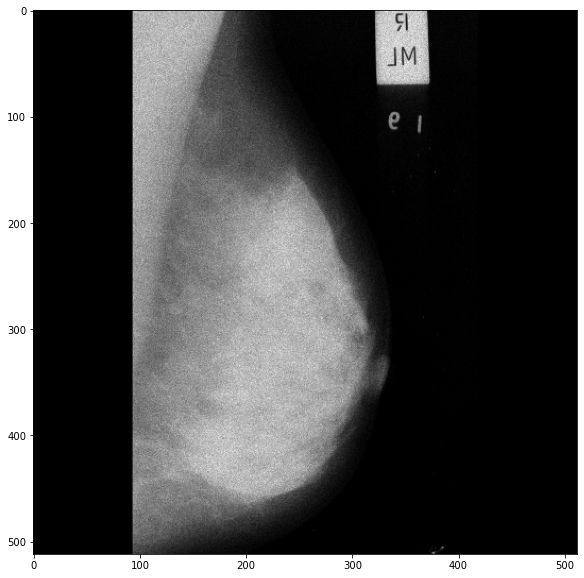

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(x_val[0])
plt.gray()

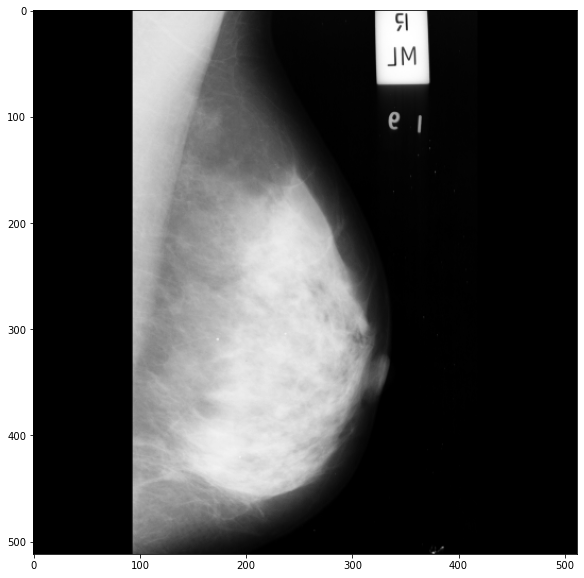

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(y_val[0])
plt.gray()